<a href="https://colab.research.google.com/github/dakingoh-uw/Public_Examples/blob/main/Inverted_Pendulum_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Support Functions!

In [33]:
# numpy = numerical Python, implements arrays (/ matrices)
import numpy as np
# limit number of decimal places printed for floating-point numbers
np.set_printoptions(precision=3)

# scipy = scientific Python, implements operations on arrays / matrices
import scipy as sp
# linalg = linear algebra, implements eigenvalues, matrix inverse, etc
from scipy import linalg as la
# optimize = optimization, root finding, etc
from scipy import optimize as op

# produce matlab-style plots
import matplotlib as mpl
# increase font size on plots
mpl.rc('font',**{'size':18})
# use LaTeX to render symbols
mpl.rc('text',usetex=False)
# animation
from matplotlib import animation as ani
# Matlab-style plotting
import matplotlib.pyplot as plt

# symbolic computation, i.e. computer algebra (like Mathematica, Wolfram Alpha)
import sympy as sym
def Jacobian(g,y,d=1e-4):
  """
  approximate derivative via finite-central-differences 

  input:
    g - function - g : R^n -> R^m
    y - n array
    (optional)
    d - scalar - finite differences displacement parameter

  output:
    Dg(y) - m x n - approximation of Jacobian of g at y
  """
  # given $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
  # $$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$
  e = np.identity(len(y))
  Dyg = []
  for j in range(len(y)):
      Dyg.append((.5/d)*(g(y+d*e[j]) - g(y-d*e[j])))
  return np.array(Dyg).T

def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(t,x,u) 

  input:
    f : T x X x U --> X - vector field
      T - time space (subset of real numbers)
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

# Inverted Pendulum

Consider the following simplified CT-DE model for an inverted pendulum, which consists of a massless rod of length $\ell$ with a point mass $m$ affixed to one end and a rotational joint affixed to the other end,
$$
m \ell^2 \ddot{q} = m g \ell \sin q - \alpha\dot{q} + \ell u \cos q,
$$
where
$q$ is the pendulum angle,
$\alpha > 0$ is a coefficient of rotational friction,
and $u$ is the horizontal acceleration of the pivot point.

____
The goal is to represent the equation in the form:
$$
\ddot{x} = Ax +Bu,
$$

Where x is the state and u is the control input.


Placing into the nonlinear state-space form:

$$\dot{x} = \frac{d}{dt}\left[\begin{array}{c} q \\ \dot{q} \end{array}\right] = \left[\begin{array}{c} \dot{q} \\ ​(−αq˙​+ℓgm \sin{q}+ℓu\cos{q})/​{ℓ^2m})​\end{array}\right] = f((q,\dot{q}),u) = f(x,u).$$

Unfortunately, since this has sin(q) and cos(q), this is nonlinear.  Nonlinear systems can be simulated, but feedback control is more difficult

## Nonlinear Simulation

I will assume $m = 1$, $\ell = 0.5$, $g = 9.81$, $\alpha = 0.25$

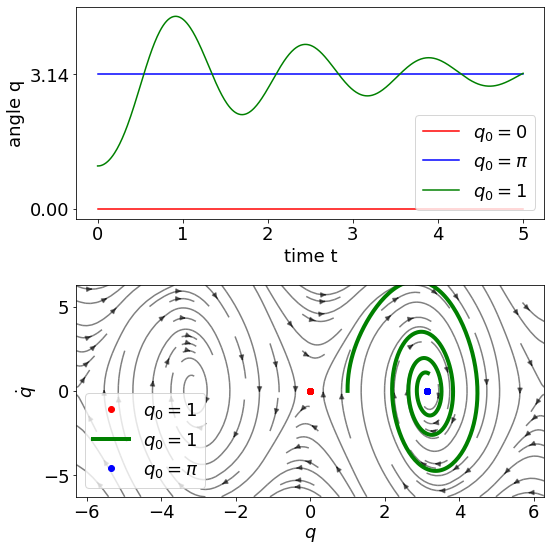

In [34]:
m = 1
l = 0.5
g = 9.81
a = 0.25

def f_NL(t,x,u):
    q,dq = x[0],x[1]
    return np.hstack([dq,(-a*dq +  l*g*m*np.sin(q) + l*u*np.cos(q))/(l**2*m)])

dt = 1e-2 # coarse timestep
t = 5
x0 = np.hstack((0.,0.)) #initial q = 0. dq = 0

# input
ut = lambda t : 0
# lambda is a shorthand way to define a function
# -- equivalently:
def ut(t):
    return 0

t_,x_ = numerical_simulation(f_NL,t,x0,dt=dt,ut=ut)




fig = plt.figure(figsize=(8,8));

ax = plt.subplot(211)
ax.plot(t_,x_[:,0],'r',label = '$q_{0} = 0$')
ax.set_ylabel(r'angle q')
ax.set_xlabel(r'time t')

x0 = np.hstack((3.14159,0.)) #initial q = 0. dq = 0
t_,x_ = numerical_simulation(f_NL,t,x0,dt=dt,ut=ut)
ax.plot(t_,x_[:,0],'b',label = '$q_{0} = \pi$')

x0 = np.hstack((1,0.)) #initial q = 0. dq = 0
t_,x_ = numerical_simulation(f_NL,t,x0,dt=dt,ut=ut)
ax.plot(t_,x_[:,0],'g',label = '$q_{0} = 1$')
plt.legend()
ax.set_yticks([0,3.14])

# phase portrait / "streamplot" / "quiver" plot
ax = plt.subplot(2,1,2)
X, Y = np.meshgrid(np.linspace(-6.28,+6.28, 11), np.linspace(-6.28, +6.28, 11))
dX,dY = np.asarray([f_NL(0.,(x,y),0.).flatten() for x,y in zip(X.flatten(),Y.flatten())]).T
dX,dY = dX.reshape(X.shape),dY.reshape(Y.shape)

ax.streamplot(X,Y,dX,dY,color=(0,0,0,.5))
ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$\dot{q}$')


# initial condition along x-axis
t_,x_ = numerical_simulation(f_NL,t,[0,0],dt=dt,ut=ut)
ax.plot(x_[:,0],x_[:,1],'ro',lw=4,label = '$q_{0} = 1$')

# initial condition along y-axis
t_,x_ = numerical_simulation(f_NL,t,[1,0],dt=dt,ut=ut)
ax.plot(x_[:,0],x_[:,1],'g',lw=4,label = '$q_{0} = 1$')

# initial condition along y-axis
t_,x_ = numerical_simulation(f_NL,t,[3.14159,0],dt=dt,ut=ut)
ax.plot(x_[:,0],x_[:,1],'bo',lw=4, label = '$q_{0} = \pi$')

ax.set_xlim((-6.28,+6.28))
ax.set_ylim((-6.28,+6.28))

plt.legend()
plt.tight_layout()

We can see from the above image that a pendulum starting anywhere other than exactly straight up (0 degrees) will eventually land at the bottom (pi radians)

# Linearization

Since the goal is to represent the equation in the form:
$$
\ddot{x} = Ax +Bu,
$$

we will do this by calculating the Jacobian (Matrix Derivative):

First, we choose an "equilibrium point" to linearize: For the inverted pendulum, it makes sense to linearize about (q,$\dot{q}$) = (0,0), as this is an equilibrium point that we will want to make stable later.


Jacobian can be caluclated as $$Df(x) =\left[\begin{array}{c} 
\frac{\partial f_{1}}{\partial x_{1}} & \frac{\partial f_{1}}{\partial x_{2}} \\
 \frac{\partial f_{2}}{\partial x_{1}} & \frac{\partial f_{2}}{\partial x_{2}} 
\end{array}\right]
=
\left[\begin{array}{c} 
\frac{\partial \dot{q}}{\partial q} & \frac{\partial \dot{q}}{\partial \dot{q}} \\
 \frac{\partial (−αq˙​+ℓgm \sin{q}+ℓu\cos{q})/​{ℓ^2m})​}{\partial q} & \frac{\partial (−αq˙​+ℓgm \sin{q}+ℓu\cos{q})/​{ℓ^2m})​}{\partial \dot{q}} 
\end{array}\right]
=
\left[\begin{array}{c} 
0 & 1 \\
 \frac{(ℓgm\cos{q}-ℓu\sin(q))}{ l^2m}& \frac{-\alpha}{ l^2m} \end{array}\right]
$$

Similarly,
$$Df(u) =\left[\begin{array}{c} 
0 \\
 \frac{\cos(q)}{ℓm}
\end{array}\right]
$$

Evaluating at equilibrium point q = 0, $\dot{q}=0$:
$$
\dot{x} = Ax + Bu = 
(Df(x)|_{x_0})x + (Df(u)|_{x_0})u=\left[\begin{array}{c} 
0 & 1\\
 \frac{g}{ℓ} & \frac{-\alpha}{ℓ^2m}
\end{array}\right]x +
\left[\begin{array}{c} 
0 \\
 \frac{1}{ℓm}
\end{array}\right]u
$$

Text(0.5, 0, 'time t')

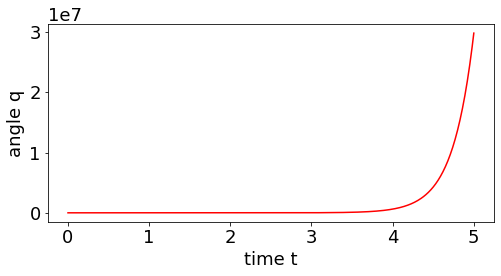

In [35]:
m = 1
l = 0.5
g = 9.81
a = 0.25

A = np.array([[0,1],[g/l,-a/(l**2*m)]])
B = np.array([[0],[1/(l*m)]])
def f(t,x,u):
    q,dq = x[0],x[1]
    return A@x + B*u

dt = 1e-2 # coarse timestep
t = 5
x0 = np.array([[.2],[0.]]) #initial q = 0. dq = 0

# input
ut = lambda t : 0
# lambda is a shorthand way to define a function
# -- equivalently:
def ut(t):
    return 0

t_,x_ = numerical_simulation(f,t,x0,dt=dt,ut=ut)


fig = plt.figure(figsize=(8,8));

ax = plt.subplot(211)
ax.plot(t_,x_[:,0],'r',label = '$q_{0} = 0$')
ax.set_ylabel(r'angle q')
ax.set_xlabel(r'time t')

Linearized system is unstable: Explodes for even small perterbations in q

# Incorporating Controller

From Before:
$$
\dot{x} = \left[\begin{array}{c} 
0 & 1\\
 \frac{g}{ℓ} & \frac{-\alpha}{ℓ^2m}
\end{array}\right]x +
\left[\begin{array}{c} 
0 \\
 \frac{1}{ℓm}
\end{array}\right]u
$$

This can be split up as follows:

$ \ddot{q} = \frac{g}{ℓ}q - \frac{\alpha}{ℓ^2m}\dot{q} + \frac{1}{ℓm}u
$

The goal here is to define a control input u such that $\ddot{q} = v$, where v is a state control law

It can be seen that $u = -ℓm(\frac{g}{ℓ}q - \frac{\alpha}{ℓ^2m}\dot{q}-\frac{v}{ℓm}) $ results in $\ddot{q} = v$

Finally,
we can decide a control law:
Example: $v = -K_P (q - q_0) - K_D \dot{q}$, where $q_0$ is the target stable reference state (For us, $q_0$ = 0 is our target)





let $Kp = 1, Kd = 1$

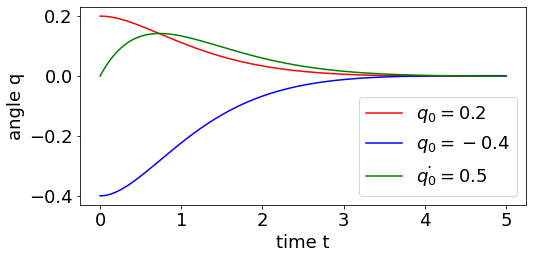

In [36]:
m = 1
l = 0.5
g = 9.81
a = 0.25
Kp = 1
Kd = 1
q_0 = 0

A = np.array([[0,1],[g/l,-a/(l**2*m)]])
B = np.array([[0],[1/(l*m)]])

def f(t,x,u):
    q,dq = x[0],x[1]
    return A@x + B*u

dt = 1e-2 # coarse timestep
t = 5
x0 = np.array([[.2],[0.]]) #initial q = .2. dq = 0

# input
def ux(x):
    q,dq = x[0],x[1]
    v = -Kp*(q-q_0)-Kd*dq
    u = -l*m*(g/l*q - a/(l*m)*dq - v/(l*m))
    return u

t_,x_ = numerical_simulation(f,t,x0,dt=dt,ux=ux)


fig = plt.figure(figsize=(8,8));

ax = plt.subplot(211)
ax.plot(t_,x_[:,0],'r',label = '$q_{0} = 0.2$')
ax.set_ylabel(r'angle q')
ax.set_xlabel(r'time t')

x0 = np.array([[-.4],[0.]]) #initial q = -0.4 dq = 0
t_,x_ = numerical_simulation(f,t,x0,dt=dt,ux=ux)
ax.plot(t_,x_[:,0],'b',label = '$q_{0} = -0.4$')
ax.set_ylabel(r'angle q')
ax.set_xlabel(r'time t')

x0 = np.array([[0],[.5]]) #initial q = 0. dq = 0.5
t_,x_ = numerical_simulation(f,t,x0,dt=dt,ux=ux)
ax.plot(t_,x_[:,0],'g',label = '$\dot{q_{0}} = 0.5$')
ax.set_ylabel(r'angle q')
ax.set_xlabel(r'time t')


plt.legend()

Even for small perterbations of angle or velocity, system is able to stabilize to 0

# Nonlinear Controlled System

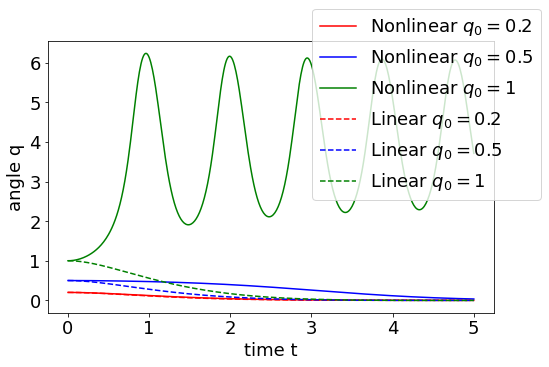

In [51]:
x0 = np.hstack((0.2,0.)) #initial q = .2. dq = 0
t_,x_ = numerical_simulation(f_NL,t,x0,dt=dt,ux=ux)

fig = plt.figure(figsize=(8,5));

#NONLINEAR
ax = plt.subplot(111)
ax.plot(t_,x_[:,0],'r',label = 'Nonlinear $q_{0} = 0.2$')
ax.set_ylabel(r'angle q')
ax.set_xlabel(r'time t')

x0 = np.hstack((.5,0.))
t_,x_ = numerical_simulation(f_NL,t,x0,dt=dt,ux=ux)
ax.plot(t_,x_[:,0],'b',label = 'Nonlinear $q_{0} = 0.5$')
ax.set_ylabel(r'angle q')
ax.set_xlabel(r'time t')

x0 = np.hstack((1,0.))
t_,x_ = numerical_simulation(f_NL,t,x0,dt=dt,ux=ux)
ax.plot(t_,x_[:,0],'g',label = 'Nonlinear $q_{0} = 1$')
ax.set_ylabel(r'angle q')
ax.set_xlabel(r'time t')


#LINEAR
x0 = np.array([[0.2],[0.]])
t_,x_ = numerical_simulation(f,t,x0,dt=dt,ux=ux)
ax.plot(t_,x_[:,0],'r--',label = 'Linear $q_{0} = 0.2$')
ax.set_ylabel(r'angle q')
ax.set_xlabel(r'time t')

x0 = np.array([[0.5],[0.]])
t_,x_ = numerical_simulation(f,t,x0,dt=dt,ux=ux)
ax.plot(t_,x_[:,0],'b--',label = 'Linear $q_{0} = 0.5$')
ax.set_ylabel(r'angle q')
ax.set_xlabel(r'time t')

x0 = np.array([[1],[0]])
t_,x_ = numerical_simulation(f,t,x0,dt=dt,ux=ux)
ax.plot(t_,x_[:,0],'g--',label = 'Linear $q_{0} = 1$')
ax.set_ylabel(r'angle q')
ax.set_xlabel(r'time t')

fig.legend()

Linearized Representation of the system is only valid for small range of angles